In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sampling_utils import plot_impulses, sampled_to_discrete, rect
from scipy.signal import unit_impulse

## Analog and digital signals

Analog signals are in essence represent quantities in the real world, those can be electrical current, sound or temperature. A important characteristic of these signals is that they're continuous, which means for any moment in time, there exists an amplitude of the signal associated with that moment.

Digital signals on the other hand exist in discrete quantities, that is, they can only assume a finite number of states and be associated to a finite number of moments in time. There are many reasons to represent an analog quantity an a discrete manner, a few examples would be easier processing, enconding, transmission, and storage. Reciprocally, digital signals are easy to work with, but except for purely numerical aplications, aren't much useful until they're converted back into analog quantities. 

The analog to digital conversion (A/D) can be modeled by the steps of sampling, quantization and sampled to discrete conversion. The digital to analog conversion (D/A) is modeled by the step of reconstuction. Both A/D and D/A will be discussed in this Notebook

Since this Notebook runs on a digital device, it's not possible to perfectly represent a continuous time signal. For that reason, we will represent continuous time signals as large arrays with an associated "time-axis" and "time slice". The first array will represent the amplitudes of the signal over time, the second one is a representation of the window in time during which we we'll be observing the signal, Finally, the "time slice" is a scalar relating the integer array-indexes we have in discrete time to moments in continuous time

## Sampling stage

The goal here is to represent an analog signal $x(t)$ with samples taken at a regular interval (known as the sampling interval). For example, telephony adopts a sampling frequency $Fs = 8000Hz$, which means the sampling interval will be $Ts = 125 \mu s$

Periodic sampling can be modeled as the multiplication of $x(t)$ by a periodic impulse train $p(t)$. The snippet below generates and depicts the impulse train for sampling at $8 kHz$. As conventionally done, the impulses heights indicate their areas. The sampled signal is denoted as
$$x_s(t) = x(t)p(t) = \sum_{k=-\infty}^{\infty} x(kTs)\delta(t - kTs)$$


where $x(kT_s)$ is the impulse area in $x_s(t)$, which coincides with the amplitude of $x(t)$ at
$t = kT_s$. The amplitude of $x_s(t)$ is not defined when $t = kTs$ and zero otherwise. The
notation $x^a_s (t)$ will sometimes be used to emphasize we mean the area of the impulse at
time $t$.

Text(0, 0.5, 'Amplitude')

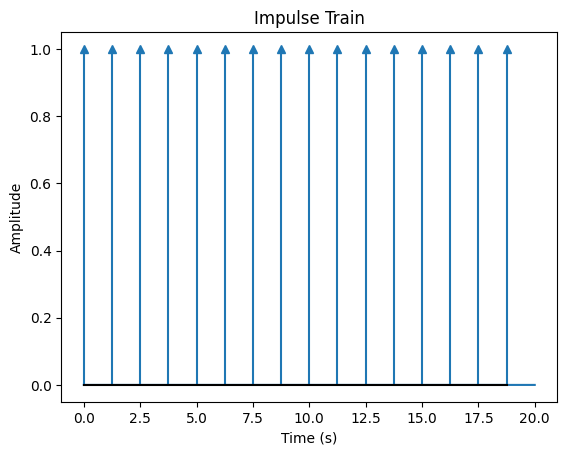

In [5]:
# Generate a time windows representing 2 ms and calculate the associated time slice
time_axis = np.linspace(0,20,10000)
time_slice = 20/10000

# Initalize an array to hold our impulse train
impulse_train = np.zeros_like(time_axis)

# Determine the "sampling period" for our impulses, so that they have 125us in distance
discrete_Ts = int((125e-6/1e-4)*(1/time_slice))

# Populate the impulse train p(t)
for i in range(len(impulse_train)):
    if i % discrete_Ts == 0:
        impulse_train += unit_impulse(shape = impulse_train.shape, idx = i)
        
# Plot out impulse train
plot_impulses(time_axis,impulse_train)
plt.title("Impulse Train")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


## Example of periodic sampling

Text(0, 0.5, 'Amplitude')

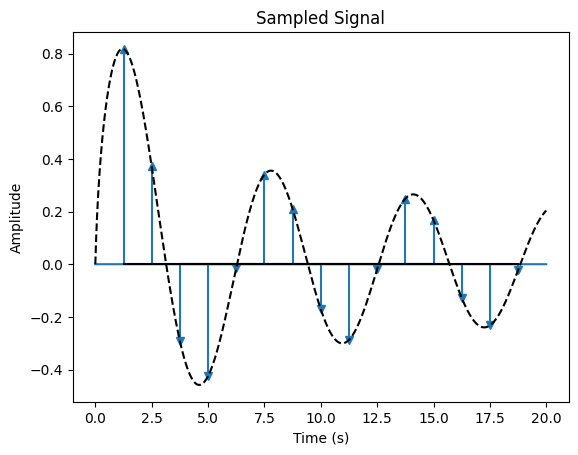

In [6]:
# Generate our signal to study
x_original = np.sin(time_axis)/np.sqrt(time_axis + 0.1)

# Multiply by our impulse train
x_sampled = x_original*impulse_train

# Plot the sampled signal
plot_impulses(time_axis,x_sampled)

# Plot the 'envelope' of the sampled signal
plt.plot(time_axis,x_original, "k--")
plt.title("Sampled Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


In terms of computational cost, it is often convenient to use the smallest possible
value of $F_{s}$. But choosing $F_{s}$ too small may lead to a sampled signal that does not
represent well the original signal. The Shannon-Nyquist sampling theorem states that in order to perfectly reconstruct a signal, the sampling frequency must be greater than twice the highest frequency component in the signal.
$$F_s > 2F_{\text{max}}$$

## Sampled to discrete conversion

After a signal is sampled, its still represented by continuous time unit impulses and though discrete, may still have real numbers on it's time-axis. The sampled to discrete (S/D) conversion represents the transition from continuous time impulses to discrete time impulses, and is always associated with a sampling period $T_s$. For example, if 
$$x_s(t) = 3\delta(t + 2T_s) - \delta(t + T_s) + 8\delta(t) - 5\delta(t - 3T_s) $$
The sampled to discrete conversion outputs
$$x[n] = 3\delta[n + 2] - \delta[n + 1] + 8\delta[n] - 5\delta[n - 3]$$
It's important to note that now $x[n]$ can be interpreted as an array, as it has only integer indexes and it's entries represent amplitudes.

Text(0, 0.5, 'x[n]')

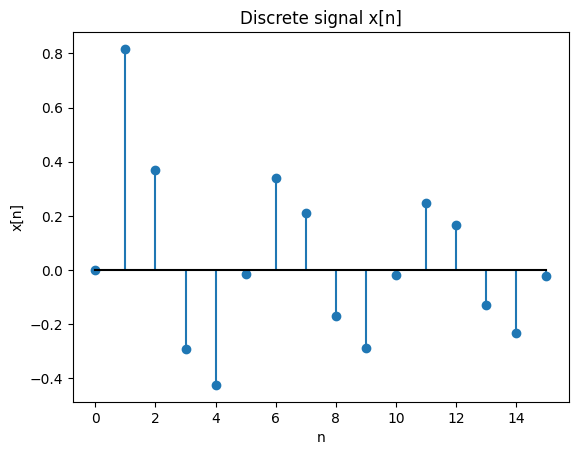

In [7]:
# Perform D/S conversion, now x_discrete can interpreted literally as an array
x_discrete = sampled_to_discrete(x_sampled,discrete_Ts)
plt.stem(x_discrete, basefmt="k-")
plt.title("Discrete signal x[n]")
plt.xlabel("n")
plt.ylabel("x[n]")

Together with sampling, the A/D conversion also has a quantization stage, which consists in mapping the infinite real-valued amplitudes of an analog signal into a finite set of discrete amplitudes. This process is of special importance when discussing data compression and numerical errors, but will be disregarded in this text as out focus is on the sampling and reconstruction aspects of A/D conversion.

# Reconstruction

While sampling converts analog signals into discrete ones, its inverse operation to sampling is called reconstruction, that is, reconstruction takes a sampled signal $x_s(t)$ and returns an analog signal $x(t)$. Reconstruction is also called interpolation or filtering. It consists of choosing a function $h(t)$
that is combined with $x_s(t)$ as follows:
$$x(t) = \sum_{n=-\infty}^{\infty} x_a[nT_s]h(t - nT_s)$$

Because $x_s(t)$ is obtained from $x[n]$ via a D/S process, it is convenient to rewrite this equation observing that the impulse area $x^a_s (nT_s)$ coincides with its corresponding
amplitude $x[n]$, such that:
$$x(t) = \sum_{n=-\infty}^{\infty} x[n]h(t - nT_s)$$

Among many alternatives for choosing the reconstruction function $h(t)$, two important
ones are the so-called zero-order holder (ZOH) $h(t) = \Pi(\frac{t − 0.5T_s}{T_s})$, where $\Pi(t)$ is the rectangle function, and sinc reconstruction $h(t) = sinc(t/T_s)$, where $sinc(t) = \frac{sin(\pi{}t)}{\pi{}t}$ and $sinc(0) = 1$. ZOH is useful for its simplicity, while sincs achieve a
perfect reconstruction. They are discussed in the next topics.

## Example: Reconstruction with ZOH

Text(0, 0.5, 'Amplitudes')

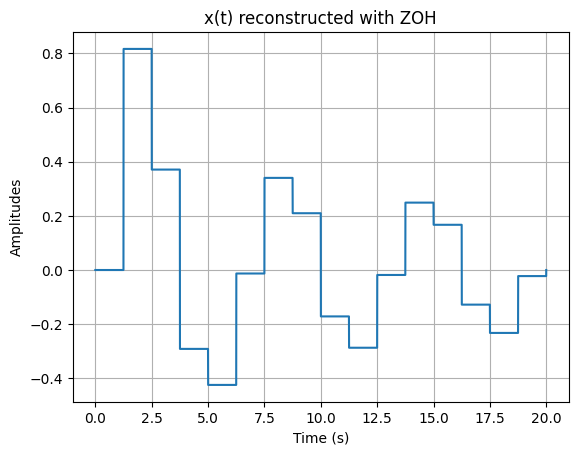

In [29]:
# Calculate the sampling period
Ts = time_slice*(len(x_original)/len(x_discrete))

# Function implementing ZOH reconstruction
def  ZOH_reconstruction(x_discrete, t, Ts):
    # Construct a delayed time axis, to avoid negative time in calculations
    time_axis = t - t[0]
    # Initialize array
    x_ZOH_reconstructed = np.zeros_like(time_axis)
    for i in range(len(x_discrete)):
        x_ZOH_reconstructed += x_discrete[i]*rect((time_axis-i*Ts - 0.5*Ts)/Ts)
    return x_ZOH_reconstructed

# Evocate our function
x_ZOH_reconstructed = ZOH_reconstruction(x_discrete, time_axis, Ts)

# Plot
plt.plot(time_axis,x_ZOH_reconstructed)
plt.grid()
plt.title("x(t) reconstructed with ZOH")
plt.xlabel("Time (s)")
plt.ylabel("Amplitudes")

The reconstructed signal does properly interpolate all of the amplitudes contained in $x[n]$. However, notice that the output is "pointy" and does not look entirely alike to the original one. This can be observed in the following figure. The upper image represents the reconstructed signal and the original $x(t)$, while the bottom image represents the absolute value of the reconstruction error.

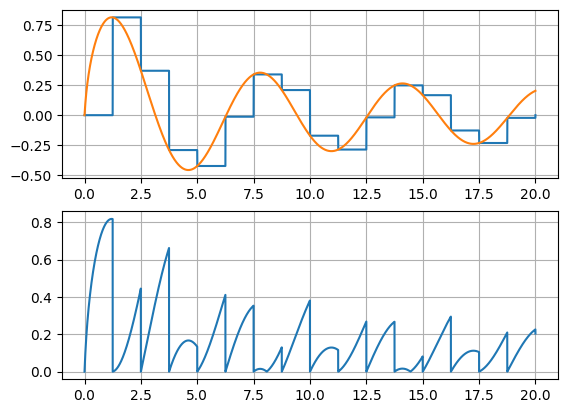

In [31]:
plt.subplot(211)
# Plot reconstructed signal
plt.plot(time_axis,x_ZOH_reconstructed)
# Plot original signal
plt.plot(time_axis,x_original)
plt.subplot(212)
# Plot the absolute value of the error
plt.plot(time_axis, abs(x_ZOH_reconstructed-x_original))

In fourrier analysis, whenever a signal contains sudden changes in amplitude, such as spikes or ponty edges, it's said that it contains high-frequency components. With this ideia in mind, we can state a notion about ZOH reconstruction in a more mathematical language, the ZOH-reconstructed signal is ponty, thus it contains more high-frequency components than the original signal. Understanding this, we can now look for an approach to reconstruction which does not add harmonics to the signal

# Example : Reconstuction with sincs

Before applying sinc reconstruction to our signal under study, applying the technique to a simpler signal is helpful for comprehending its properties. The following figure displays a discrete signal $y[n]$ in its topmost plot, followed by $y^a_s(t)$, converted to a sampled signal. Finally, $y(s)$, reconstructed with sincs

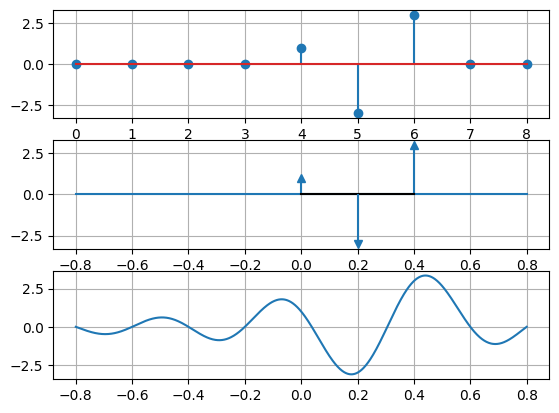

In [51]:
# Function which implements sinc reconstruction
def sinc_interpolation(x_discrete,t,Ts):
    time_axis = t - t[0]

    x_sinc_reconstructed = np.zeros_like(time_axis)
    for i in range(len(x_discrete)):
        x_sinc_reconstructed += x_discrete[i]*np.sinc((time_axis-i*Ts)/Ts)
    
    return x_sinc_reconstructed

# Simple discrete signal
y = np.array([1,-3,3])
# Create a larger 'frame' to visualize the signal
n_frame = 4
N = len(y)
y_framed = np.zeros(2*n_frame + 1)
y_framed[n_frame:n_frame+N] = y
# Plot y as a discrete signal
plt.subplot(311)
plt.stem(y_framed)
plt.grid()

# Plot y as a sampled signal
plt.subplot(312)
y_Ts = 0.2
plot_impulses(y_Ts*np.arange(-n_frame,n_frame+1), y_framed)
plt.grid()

# Reconstruct y with sincs
y_time_axis = np.linspace(0, (len(y_framed) - 1)*y_Ts,1000) - n_frame*y_Ts
y_sinc_reconstructed = sinc_interpolation(y_framed,y_time_axis, y_Ts)

# Plot y sinc reconstructed
plt.subplot(313)
plt.plot(y_time_axis,y_sinc_reconstructed)
plt.xticks(y_Ts*np.arange(-n_frame,n_frame+1))
plt.grid()

One can notice that $sinc(t)$ functions are smooth in contrast to $\Pi(t)$ which have discontinuous edges. This already gives an intuitive clue that sincs may achive a better reconstruction in comparison to ZOH. Yet another property of sinc functions is that their periodicy guarantees a sample's amplitude will not affect the amplitude at any multiple of the sampling period other than itself, as $sinc(t)$ will have zeros at these positions. The following figure takes a closer look at the reconstructed signal

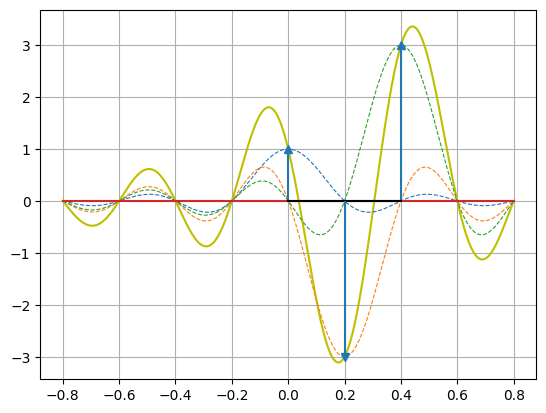

In [53]:
# Plot full reconstructed signal
plt.plot(y_time_axis, y_sinc_reconstructed, y_Ts, color = 'y')
plt.xticks(y_Ts*np.arange(-n_frame,n_frame+1))
plt.grid()

# Get every sinc parcel in the reconstruction
y_sinc_parcels = np.zeros((len(y), len(y_time_axis)))
for i in range(N):
    single_sample = np.zeros_like(y_framed)
    single_sample[n_frame+i] = y_framed[n_frame+i]
    y_sinc_parcels[i] = sinc_interpolation(single_sample, y_time_axis, y_Ts)

# Plot every parcel
for sinc_parcel in y_sinc_parcels:
    plt.plot(y_time_axis,sinc_parcel, linestyle='dashed',linewidth = 0.8)
# Plot every impulse
plot_impulses(y_Ts*np.arange(-n_frame,n_frame+1), y_framed)


From the observed, its clear that mathematically sinc reconstruction is superior to ZOH. In fact, reconstruction with sincs is also called perfect reconstruction, as this method is the only one which does not add any high-frequency components to the reconstructed signal. Also, given an infinite number of samples (which is not possible for real world signals, but once again is a useful formalism in math), perfect reconstruction can fully return a sampled signal to a continuous signal, with error equal to zero. Now, we finally apply sinc reconstruction to our $x[n]$ signal.

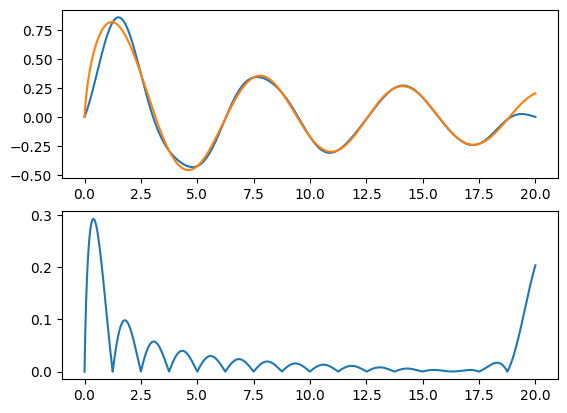

In [54]:
x_sinc_reconstructed = sinc_interpolation(x_discrete, time_axis, Ts)

plt.subplot(211)
plt.plot(time_axis,x_sinc_reconstructed)
plt.plot(time_axis,x_original)
plt.subplot(212)
plt.plot(time_axis, abs(x_sinc_reconstructed-x_original))


In conclusion, we observe a far smaller error coming from sinc reconstruction when compared to ZOH for a constant number of samples, though the reconstruction error is not zero, this can be understood as a limitation of our analysis, as we are not working with infinite duration discrete signals, for which case the error is expected to be zero.